# Neural Network Approximator for Black–Scholes Implied Volatility
This notebook ingests an options CSV (e.g. generated via `download_options.py TICKER`) and trains a small neural network that maps option descriptors `(S0, K, T, C_mkt, moneyness)` to the Black–Scholes implied volatility computed via numerical inversion.

## 1. Imports and configuration

In [23]:
%matplotlib inline

import math
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)
plt.style.use("seaborn-v0_8")
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = lambda x: f"{x:,.6f}"
print(f'Using torch {torch.__version__}')


Using torch 2.5.1


## 2. Load dataset

In [ ]:
DATA_TICKER = "SPY"  # change to match your CSV
local_candidate = Path(f"options_{DATA_TICKER}.csv")
parent_candidate = Path('..') / local_candidate
if local_candidate.exists():
    CSV_PATH = local_candidate
elif parent_candidate.exists():
    CSV_PATH = parent_candidate
else:
    raise FileNotFoundError(f"CSV not found near notebook: {local_candidate} / {parent_candidate}")

df = pd.read_csv(CSV_PATH)
required_cols = {"S0", "K", "C_mkt", "T"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")
print(f'Loaded {CSV_PATH} with shape {df.shape}')
display(df.head())


## 3. Black–Scholes pricing helpers and implied volatility target

In [25]:
def normal_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def bs_call_price(S0: float, K: float, T: float, r: float, q: float, vol: float) -> float:
    if T <= 0:
        return max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0)
    vol = max(vol, 1e-8)
    sqrt_T = math.sqrt(T)
    d1 = (math.log(S0 / K) + (r - q + 0.5 * vol * vol) * T) / (vol * sqrt_T)
    d2 = d1 - vol * sqrt_T
    discount_dom = math.exp(-r * T)
    discount_for = math.exp(-q * T)
    return S0 * discount_for * normal_cdf(d1) - K * discount_dom * normal_cdf(d2)

def implied_vol_bs(C_mkt: float, S0: float, K: float, T: float, r: float, q: float = 0.0) -> float:
    if T <= 0 or C_mkt <= 0:
        return float("nan")
    intrinsic = max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0)
    if C_mkt < intrinsic - 1e-10:
        return float("nan")

    def objective(vol: float) -> float:
        return bs_call_price(S0, K, T, r, q, vol) - C_mkt

    lo, hi = 1e-4, 0.5
    value_hi = bs_call_price(S0, K, T, r, q, hi)
    while value_hi < C_mkt and hi < 5.0:
        hi *= 2
        value_hi = bs_call_price(S0, K, T, r, q, hi)
    if value_hi < C_mkt:
        return float("nan")
    for _ in range(80):
        mid = 0.5 * (lo + hi)
        f_mid = objective(mid)
        if abs(f_mid) < 1e-8:
            return mid
        if f_mid > 0:
            hi = mid
        else:
            lo = mid
    return mid

RISK_FREE = 0.02
DIVIDEND = 0.0
sigmas = []
for _, row in df.iterrows():
    sigma = implied_vol_bs(row['C_mkt'], row['S0'], row['K'], row['T'], RISK_FREE, DIVIDEND)
    sigmas.append(sigma)
df['sigma_BS'] = sigmas
print('Computed implied vol for all rows.')
display(df[['S0','K','T','C_mkt','sigma_BS']].head())
display(df['sigma_BS'].describe())


Computed implied vol for all rows.


,S0,K,T,C_mkt,sigma_BS
0,677.630127,350.000000,0.000950,0.010000,NaN
1,677.630127,355.000000,0.000950,0.020000,NaN
2,677.630127,360.000000,0.000950,0.010000,NaN
3,677.630127,365.000000,0.000950,0.010000,NaN
4,677.630127,370.000000,0.000950,0.010000,NaN


count   4,331.000000
mean        0.376978
std         0.547036
min         0.027999
25%         0.156862
50%         0.218853
75%         0.359824
max         7.964925
Name: sigma_BS, dtype: float64

## 4. Feature engineering and tensors

In [26]:
df = df.dropna(subset=['S0','K','T','C_mkt','sigma_BS']).copy()
df = df[(df['S0'] > 0) & (df['K'] > 0) & (df['T'] > 0)]
df['moneyness'] = df['S0'] / df['K']
feature_cols = ['S0','K','T','C_mkt','moneyness']
X = df[feature_cols].values.astype(np.float32)
y = df['sigma_BS'].values.astype(np.float32).reshape(-1, 1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0
X_norm = (X - X_mean) / X_std
X_tensor = torch.from_numpy(X_norm)
y_tensor = torch.from_numpy(y)
dataset = TensorDataset(X_tensor, y_tensor)
print(f'Dataset size: {len(dataset)} samples')


Dataset size: 4331 samples


## 5. Train/validation split and loaders

In [27]:
val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
print(f'Train size: {train_size}, Validation size: {val_size}')


Train size: 3465, Validation size: 866


## 6. Define neural network

In [28]:
class ImpliedVolNet(nn.Module):
    def __init__(self, input_dim: int, hidden: Tuple[int, int] = (64, 64)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden[0]),
            nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]),
            nn.ReLU(),
            nn.Linear(hidden[1], 1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
model = ImpliedVolNet(input_dim=X_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)


ImpliedVolNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 7. Training loop

Epoch 001 | Train RMSE 0.5161 | Val RMSE 0.4264
Epoch 020 | Train RMSE 0.3258 | Val RMSE 0.2980
Epoch 040 | Train RMSE 0.2795 | Val RMSE 0.2681
Epoch 060 | Train RMSE 0.2456 | Val RMSE 0.2557
Epoch 080 | Train RMSE 0.2087 | Val RMSE 0.2564
Epoch 100 | Train RMSE 0.1992 | Val RMSE 0.2950
Epoch 120 | Train RMSE 0.1588 | Val RMSE 0.2319
Epoch 140 | Train RMSE 0.1391 | Val RMSE 0.2321
Epoch 160 | Train RMSE 0.1693 | Val RMSE 0.2063
Epoch 180 | Train RMSE 0.1371 | Val RMSE 0.2002
Epoch 200 | Train RMSE 0.2833 | Val RMSE 0.2397


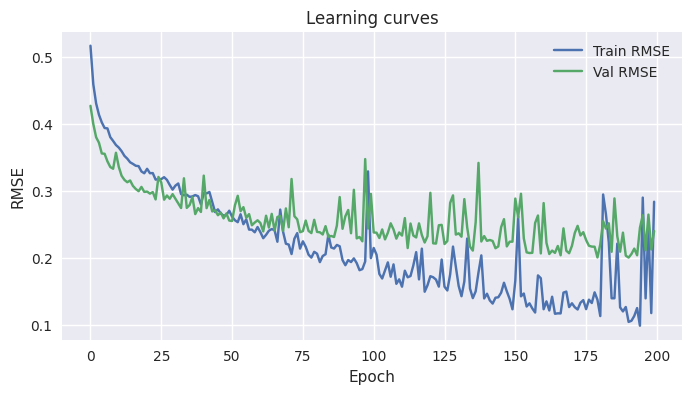

In [29]:
def run_epoch(loader, train: bool = True):
    total_loss = 0.0
    count = 0
    if train:
        model.train()
    else:
        model.eval()
    for batch_x, batch_y in loader:
        if train:
            optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
        count += batch_x.size(0)
    return math.sqrt(total_loss / count)

epochs = 200
train_history, val_history = [], []
for epoch in range(1, epochs + 1):
    train_rmse = run_epoch(train_loader, train=True)
    val_rmse = run_epoch(val_loader, train=False)
    train_history.append(train_rmse)
    val_history.append(val_rmse)
    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch {epoch:03d} | Train RMSE {train_rmse:.4f} | Val RMSE {val_rmse:.4f}')

plt.figure(figsize=(8,4))
plt.plot(train_history, label='Train RMSE')
plt.plot(val_history, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning curves')
plt.show()


## 8. Evaluate and compare predictions

Overall RMSE vs BS target: 0.2411


,S0,K,T,C_mkt,sigma_BS,sigma_pred
17,677.630127,430.000000,0.000950,248.860000,7.574627,2.097226
39,677.630127,510.000000,0.000950,173.820000,7.205751,1.964833
41,677.630127,515.000000,0.000950,168.830000,7.018000,1.974484
43,677.630127,520.000000,0.000950,163.940000,6.861543,1.946000
46,677.630127,530.000000,0.000950,156.600000,7.200367,1.988957


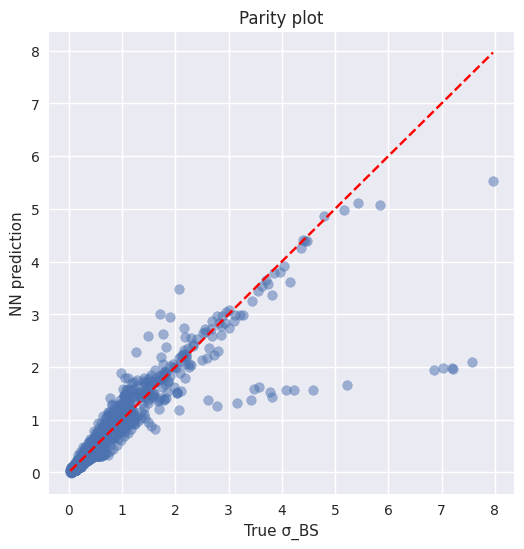

In [30]:
model.eval()
with torch.no_grad():
    preds = model(X_tensor).numpy().squeeze()
df['sigma_pred'] = preds
rmse_all = math.sqrt(np.mean((df['sigma_pred'] - df['sigma_BS']) ** 2))
print(f'Overall RMSE vs BS target: {rmse_all:.4f}')
display(df[['S0','K','T','C_mkt','sigma_BS','sigma_pred']].head())
plt.figure(figsize=(6,6))
plt.scatter(df['sigma_BS'], df['sigma_pred'], alpha=0.5)
plt.plot([df['sigma_BS'].min(), df['sigma_BS'].max()], [df['sigma_BS'].min(), df['sigma_BS'].max()], 'r--')
plt.xlabel('True σ_BS')
plt.ylabel('NN prediction')
plt.title('Parity plot')
plt.show()


## 10. Visualize NN-implied volatility surface

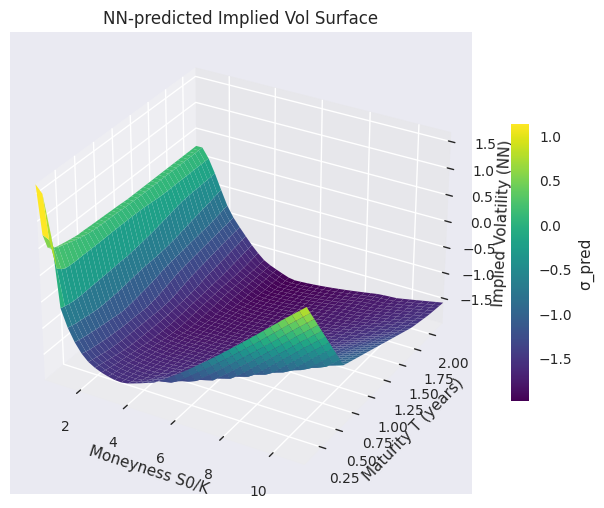

In [31]:
# Build a grid over maturity and moneyness, feeding the NN to get predicted σ.
m_grid = np.linspace(df['moneyness'].min(), df['moneyness'].max(), 40)
t_grid = np.linspace(df['T'].min(), df['T'].max(), 40)
T_mesh, M_mesh = np.meshgrid(t_grid, m_grid, indexing='ij')
# Use median S0 and C_mkt scaling from the dataset as stabilizers.
S0_ref = df['S0'].median()
price_ref = df['C_mkt'].median()
inputs = []
for t_val in t_grid:
    for m_val in m_grid:
        strike = S0_ref / max(m_val, 1e-8)
        inputs.append([S0_ref, strike, t_val, price_ref, m_val])
grid_array = np.array(inputs, dtype=np.float32)
grid_norm = (grid_array - X_mean) / X_std
with torch.no_grad():
    sigma_grid = model(torch.from_numpy(grid_norm)).numpy().reshape(len(t_grid), len(m_grid))

m_min, m_max = float(M_mesh.min()), float(M_mesh.max())
t_min, t_max = float(T_mesh.min()), float(T_mesh.max())
sigma_min, sigma_max = float(sigma_grid.min()), float(sigma_grid.max())

from mpl_toolkits.mplot3d import Axes3D  # noqa
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(M_mesh, T_mesh, sigma_grid, cmap='viridis', edgecolor='none')
ax.set_title('NN-predicted Implied Vol Surface')
ax.set_xlabel('Moneyness S0/K')
ax.set_ylabel('Maturity T (years)')
ax.set_zlabel('Implied Volatility (NN)')
ax.set_xlim(m_min, m_max)
ax.set_ylim(t_min, t_max)
ax.set_zlim(sigma_min, sigma_max)
fig.colorbar(surf, shrink=0.6, aspect=15, label='σ_pred')
plt.show()


## 9. Helper for single-sample inference

In [32]:
def predict_sigma(option_row: dict) -> float:
    vec = np.array([[option_row['S0'], option_row['K'], option_row['T'], option_row['C_mkt'], option_row['S0']/option_row['K']]], dtype=np.float32)
    vec_norm = (vec - X_mean) / X_std
    with torch.no_grad():
        pred = model(torch.from_numpy(vec_norm)).item()
    return pred

sample = df.iloc[0]
print('Example prediction:', predict_sigma({'S0': sample['S0'], 'K': sample['K'], 'T': sample['T'], 'C_mkt': sample['C_mkt']}))
print('True σ_BS:', sample['sigma_BS'])


Example prediction: 2.097226619720459
True σ_BS: 7.5746269648257645
